## Importing libraries

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights
from torchvision.io import read_image
import torch.nn as nn
import torch.optim as optim
import cv2
from PIL import Image
import os
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re

## Feature extraction

In [2]:
device = "cuda:0"

In [3]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1,progress=True)

In [4]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
def read_images(folder,transform):
    features = {}
    for image in tqdm(os.listdir(folder)):
        Img = Image.open(os.path.join(folder,image))
        key = image.split(".jpg")[0]
        with torch.no_grad():
            features[key] = model(transform(Img).unsqueeze(0))
    return features


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
    ]
)
# images = read_images("../input/flickr8k/Images",transform)

In [ ]:
pickle.dump(images,open("../working/features.pkl","wb"))

In [8]:
images = pickle.load(open("../input/features1/features1.pkl","rb"))


## Cleaning features and processing captions

In [9]:
for k,v in images.items():
    v.squeeze_()

In [10]:
def read_captions(filename="../input/flickr8k/captions.txt"):
    captions = {}
    with open(filename,'r') as f:
        
        s = f.readline()
        s = f.readline()
        while s is not None:
            text = s.split(".jpg,")
            if not len(text) == 2:
                break
            id,caption = text[0],text[1].lower()
            if id not in captions.keys():
                captions[id] = []
            caption = re.sub('[^A-Za-z0-9]',' ',caption)
            caption = re.sub('\s+',' ',caption)
            captions[id].append("startseq " + " ".join([word for word in caption.split() if len(word) > 1]) + " endseq")
            s = f.readline()
    return captions
captions = read_captions()
print(len(captions))

8091


In [11]:
def clean(captions):
    clean_captions = {}
    for key in captions.keys():
        clean_captions[key] = []
        for caption in captions[key]:
            clean_captions[key].append(nltk.tokenize.word_tokenize(caption.lower()))
    return clean_captions        


In [12]:
cleaned_captions = clean(captions)
len(cleaned_captions)

8091

In [13]:
keys = list(images.keys())
# print(len(keys))
train_split = keys[:(len(keys)*9)//10]
# val_split = keys[(len(keys)*7)//10:(len(keys)*8)//10]
test_split = keys[(len(keys)*9)//10:]

In [14]:
word_to_index = {}
index_to_word = {}
vocab = set()
vocab.add("startseq")
vocab.add("endseq")

for key,captionl in cleaned_captions.items():
    for caption in captionl:
        vocab = vocab.union(caption)
vocab = list(vocab)



for i,word in enumerate(vocab):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [15]:
print(len(vocab))

8465


In [16]:
def tensorize_sentences(cleaned_captions,word_to_index,index_to_word):
    tensor_captions = {}
    for key in cleaned_captions.keys():
        tensor_captions[key] = []
        for caption in cleaned_captions[key]:
            tokenized_caption = []
            for token in caption:
                tokenized_caption.append(word_to_index[token])
            tensor_captions[key].append(tokenized_caption)
    return tensor_captions
captions = tensorize_sentences(cleaned_captions,word_to_index,index_to_word)

## Data Generator

In [17]:
def data_generator(features,captions,data_keys,max_len,word_to_ind,vocab,batch_size,n_epochs=None):
    X1 = []
    X2 = [] 
    y = []
    n = 0
    k = 0
    while 1:
        
        for key in data_keys:
            n += 1
            for caption in captions[key]:
                for i in range(1,len(caption)):
#                     print(type(i))
                    in_seq = caption[:i]
                    out_seq = caption[i]
                    in_seq =  (max_len-len(in_seq))*[0] + in_seq
                    X1.append(features[key].numpy())
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                n = 0
                X1 = np.array(X1)
                X2 = np.vstack(X2)
                X1 = torch.from_numpy(X1)
                X2 = torch.from_numpy(X2).squeeze_()
                y = torch.tensor(y)
                yield X1, X2, y
                
                X1 = []
                X2 = []
                y = []
        k += 1
               

In [18]:
def get_string(tokens,index_to_word):
    s = ' '.join([index_to_word[ind] for ind in tokens])
    return s

In [19]:
max_len = 0
s = 0
for caption in captions.values():
    for capt in caption:
        if(len(capt) > max_len):
            s = capt
        max_len = max(max_len,len(capt))
max_len

35

## Captioning Model Architecture

In [20]:
class Model(nn.Module):
    def __init__(self,vocab_size, embedding_dim):
        super().__init__()
        self.text_processing = nn.Sequential(
            nn.Embedding(vocab_size + 1, embedding_dim, padding_idx=0),
            nn.Dropout(0.4),
            nn.LSTM(embedding_dim,256,batch_first=True),
                                       )
        self.image_processing = nn.Sequential(
            nn.Linear(4096,embedding_dim),
            nn.BatchNorm1d(num_features=embedding_dim),
            nn.Dropout(0.4),
            nn.ReLU(),
                                              )
        
        self.final = nn.Sequential(
            nn.Linear(2*embedding_dim,1024),
            nn.BatchNorm1d(num_features=1024),
            nn.Dropout(0.4),
            nn.Linear(1024,vocab_size + 1)
            )
    
    def forward(self,X1,X2):
        _,(output1,_) = self.text_processing(X2)
        output2 = self.image_processing(X1.to(dtype=torch.float32))
        ll = torch.concatenate((output1[0].to(dtype=torch.float32),output2),dim=-1)
        fo = self.final(ll)
        return nn.LogSoftmax(dim=-1)(fo)
        

In [21]:
torch.set_default_dtype(torch.float32)

In [22]:
def init_weights(m):
    if isinstance(m,nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [33]:
captioner = Model(len(vocab), 256).to(device=device)
captioner = captioner.apply(init_weights)

## Training

In [40]:
epochs = 50
batch_size = 128
captioner.train()
optimizer = optim.Adam(captioner.parameters(),lr=0.005,betas=(0.9,0.999),weight_decay=1e-4)
crit = nn.NLLLoss()
losses = []
pbar=  tqdm(range(epochs))
min_loss = torch.inf
for i in pbar:
    gen = data_generator(images,captions,train_split,max_len,word_to_index,vocab,batch_size,n_epochs=1)
    bloss = 0
    for i,data in (enumerate(gen)):
        op = captioner(data[0].to(device=device),data[1].to(device=device))
        loss = crit(op,data[2].to(device=device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        bloss += loss.detach().clone().to(device="cpu").numpy()
        
        if i == (len(train_split)//batch_size):
            if bloss < min_loss: 
                torch.save(captioner.state_dict(),"610_2.pt")           
                min_loss = bloss
            break
    losses.append(bloss)
    pbar.set_description(f"Loss {bloss}")
        
        
    
    

Loss 161.16002583503723: 100%|██████████| 50/50 [20:45<00:00, 24.91s/it]


## Loss vs epochs

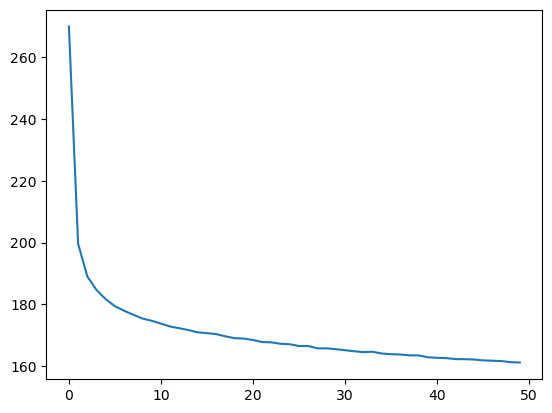

In [42]:
plt.plot(np.arange(len(losses)),losses)

## Predictions

In [34]:
captioner.load_state_dict(torch.load("610_2.pt"))

<All keys matched successfully>

In [43]:
def tokenize_sentence(sentence,word_to_index):
    nseq = []
    for token in sentence.split():
        nseq.append(word_to_index[token])
    return nseq\

def predict_caption(model,image,word_to_index,index_to_word,max_len):
    pred = "startseq "
    model.eval()
    for i in range(max_len):
        sequence = tokenize_sentence(pred,word_to_index)
        sequence = (max_len - len(sequence))*[0] + sequence
        sequence = torch.from_numpy(np.array(sequence))
        with torch.no_grad():
            op = model(image.to(device=device),sequence.unsqueeze(0).to(device=device)).to(device="cpu")
        word = index_to_word[int(op[0].argmax(0))]
        pred += word
        pred += " "
        if word == "endseq":
            break
    return pred
    

In [44]:
def format_pred(pred):
    formatted_pred = pred[len("startseq")+1:len(pred)-len("endseq")-2]
    return formatted_pred

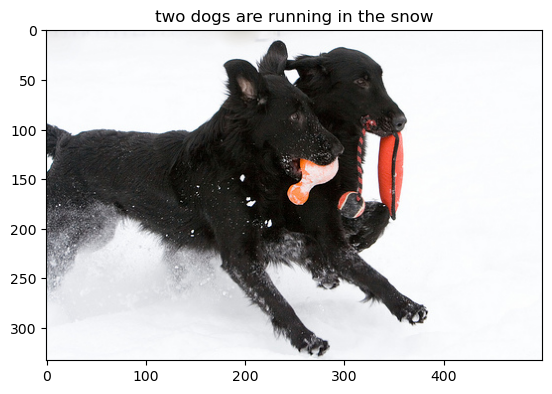

In [88]:
key1 = "3131632154_098f86f4cb"
img1 = images[key1]
# 
predicted = (format_pred(predict_caption(captioner,img1.unsqueeze(0),word_to_index,index_to_word,max_len)))
image_name = key1 + ".jpg"
image = Image.open(os.path.join("../input/flickr8k/Images/" + image_name))
plt.title(predicted)
plt.imshow(image)
# print(cleaned_captions[key1])

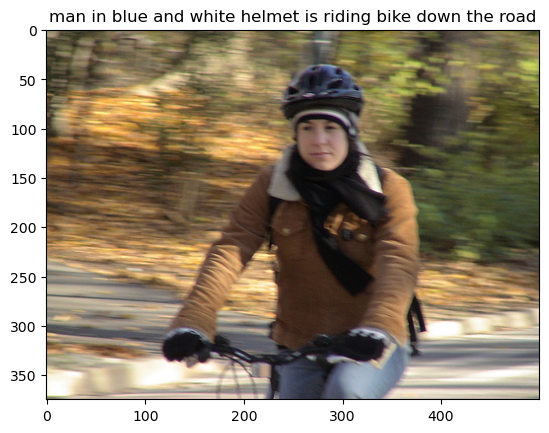

In [92]:
key1 = "2070831523_5035d5537e"
img1 = images[key1]
# 
predicted = (format_pred(predict_caption(captioner,img1.unsqueeze(0),word_to_index,index_to_word,max_len)))
image_name = key1 + ".jpg"
image = Image.open(os.path.join("../input/flickr8k/Images/" + image_name))
plt.title(predicted)
plt.imshow(image)
# print(cleaned_captions[key1])

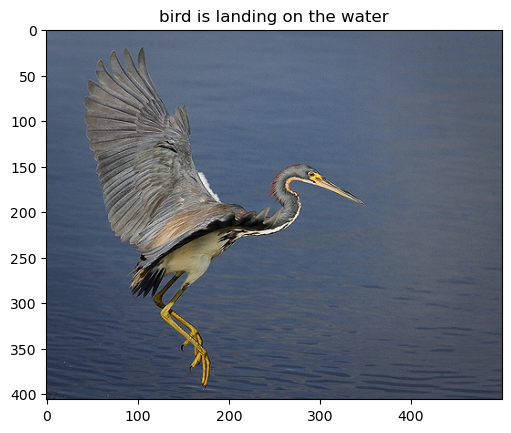

In [47]:
key1 = "3405113041_4b72c24801"
img1 = images[key1]
# 
predicted = (format_pred(predict_caption(captioner,img1.unsqueeze(0),word_to_index,index_to_word,max_len)))
image_name = key1 + ".jpg"
image = Image.open(os.path.join("../input/flickr8k/Images/" + image_name))
plt.title(predicted)
plt.imshow(image)
# print(cleaned_captions[key1])

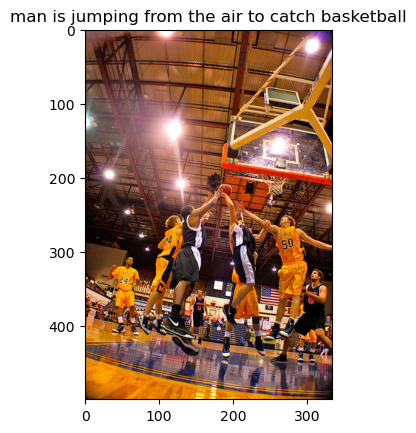

In [93]:
key1 = "3053743109_a2d780c0d2"
img1 = images[key1]
# 
predicted = (format_pred(predict_caption(captioner,img1.unsqueeze(0),word_to_index,index_to_word,max_len)))
image_name = key1 + ".jpg"
image = Image.open(os.path.join("../input/flickr8k/Images/" + image_name))
plt.title(predicted)
plt.imshow(image)
# print(cleaned_captions[key1])

In [50]:
torch.save(captioner.state_dict(),"610_2.pt")

## Evaluation

In [48]:
def bleu(captioner,test_split):
    captioner.eval()
    actual = [] 
    predicted = []
    for key in tqdm((test_split)):
        pred = predict_caption(captioner,images[key].unsqueeze(0),word_to_index,index_to_word,max_len)
        act = [caption for caption in cleaned_captions[key]]
        actual.append(act)
        predicted.append(pred.split())
    bleu1 = nltk.translate.bleu_score.corpus_bleu(actual,predicted,weights=[1.0,0.0,0.0,0.0])
    bleu2 = nltk.translate.bleu_score.corpus_bleu(actual,predicted,weights=[0.5,0.5,0.0,0.0])
    return bleu1,bleu2


In [49]:
bleu(captioner,test_split)

100%|██████████| 810/810 [00:10<00:00, 74.50it/s]


(0.5584699453551912, 0.32516810699645116)

In [89]:
# n = 0
# for key in test_split:
#     img1 = images[key]
#     key1 = key
#     if n == 18:
#         break
#     n += 1

In [90]:
# key

'3053743109_a2d780c0d2'